In [130]:
%matplotlib inline

import os
import imp
import random
import itertools

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt

import climatools.io.cesm as climaio
import climatools.aerosol.aerosol as climaaerosol
import climatools.aerosol.aerosol_constants as aeroconst
import climatools.units as climaunits
import climatools.viz as climaviz

imp.reload(climaio)
imp.reload(climaaerosol)
imp.reload(aeroconst)
imp.reload(climaunits)
imp.reload(climaviz)

<module 'climatools.viz' from '/nuwa_cluster/home/jackyu/climatools/climatools/viz.py'>

In [3]:
dir_ozone = '/nuwa_data/data/cesm1/inputdata/atm/cam/ozone'
dir_camhist = '/scratch/lupin/cesm1/archive/f19_g16.B1850.std/atm/hist'

In [116]:
# original ozone concentration from data file
ds_o3 = climaaerosol.OZONE_DATASET

da_o3 = ds_o3['O3']

# get vertical pressure
ds_o3 = climaunits.hybrid2mbar(ds_o3)

In [11]:
# open one of the CAM history files to get `lev` for 30 layers
filepath_camhist = os.path.join(dir_camhist,
                                random.choice(os.listdir(dir_camhist)))
ds_camhist = xr.open_dataset(filepath_camhist, decode_cf=False)

In [118]:
# interpolate ozone concentration along `lev` 
levinterpfunc_da_o3 = climaaerosol.get_interpfunc(da_o3, dim='lev')

# get ozone concentration for CAM history's `lev` 
da_o3_levinterp = levinterpfunc_da_o3(coords=ds_camhist.coords['lev'])

# get vertical pressure
ds_camhist = climaunits.hybrid2mbar(ds_camhist)



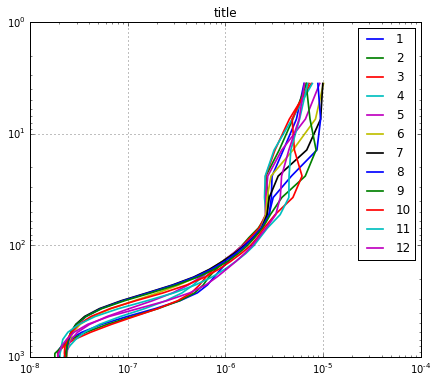

In [111]:
srss_o3 = [da_o3.isel(lat=5, lon=9, time=itime)
           .to_pandas()
           for itime, time
           in enumerate(da_o3.coords['time'])]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))

ax = climaviz.plot_pandas_series(srss=srss_o3, ax=ax,
                                 values_vs_index=True,
                                 logy=True, inverty=True,
                                 logx=True)

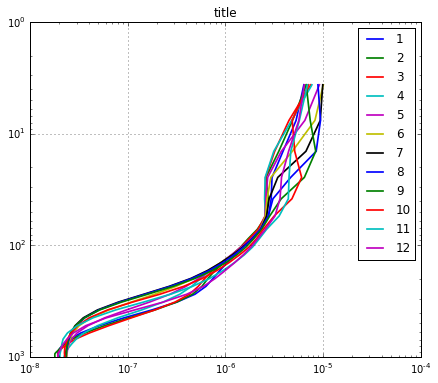

In [109]:
srss_o3_levinterp = [da_o3_levinterp.isel(lat=5, lon=9, time=itime)
                     .to_pandas() 
                     for itime, time 
                     in enumerate(da_o3_levinterp.coords['time'])]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,6))


ax = climaviz.plot_pandas_series(srss=srss_o3_levinterp, ax=axs,
                                 values_vs_index=True,
                                 logy=True, inverty=True,
                                 logx=True)

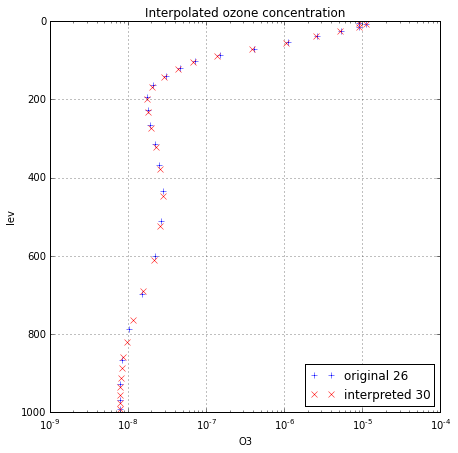

In [137]:
lat, lon, time = 40, 80, 10

srs_o3 = da_o3.isel(lat=lat, lon=lon, time=time).to_pandas()

srs_o3_interp = da_o3_levinterp.isel(lat=lat, 
                                     lon=lon, time=time).to_pandas()

srss = [srs_o3, srs_o3_interp]
names = ['original 26', 'interpreted 30']
colours = ['b', 'r']
markers = ['+', 'x']
linestyles = ['None', 'None']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
ax = climaviz.plot_pandas_series(srss=srss, ax=ax, 
                                 title='Interpolated ozone concentration',
                                 values_vs_index=True,
                                 names=names,
                                 colours=colours, markers=markers,
                                 linestyles=linestyles,
                                 logy=False, inverty=True, ylabel='lev',
                                 logx=True, xlabel='O3')